get data
unit is dBm


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
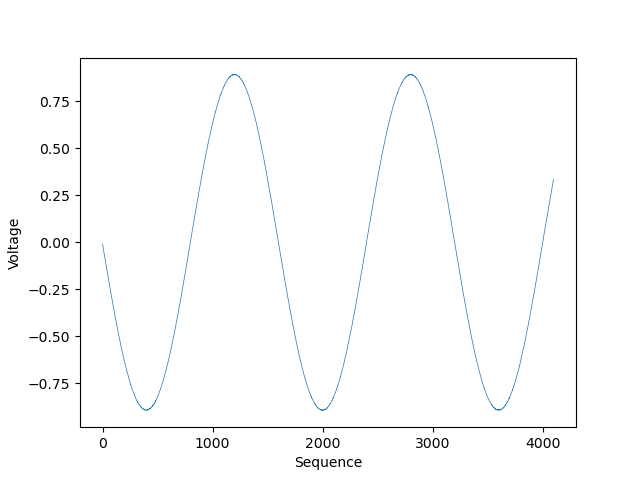

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
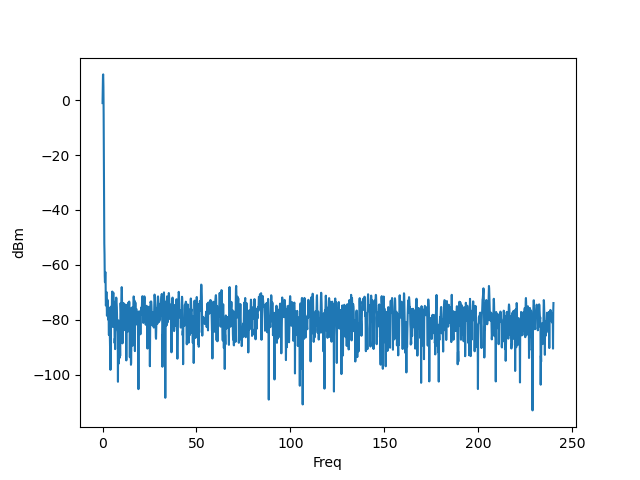

In [1]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
# vim:fenc=utf-8
#
# Copyright © 2021 gq <gq@gqhp>
#
# Distributed under terms of the MIT license.

"""
test DAC sampling
"""
%matplotlib widget

import socket
import numpy as np

from numpy.fft import fft,rfft,rfftfreq
import matplotlib.pyplot as plt

src_udp_ip = "192.168.90.20"
src_udp_port = 59000


udp_ip = "192.168.90.100"
udp_port = 60000

sock = socket.socket(socket.AF_INET,  socket.SOCK_DGRAM, socket.IPPROTO_UDP)
sock.bind((udp_ip, udp_port))
# sock.setsockopt(socket.SO_NO_CHECK,1)


# sock.setsockopt(socket.IPPROTO_UDP, 1, 1)

# sock.connect((src_udp_ip, src_udp_port))
# data, addr=sock.recvfrom(8000)

packet_size = 8192
size = 8200

udp_data = sock.recv(size)
udp_data = memoryview(udp_data)

print("get data")

chunk = np.frombuffer(udp_data[0:packet_size], dtype='>i2')

scale_f = 4.0/ (2 ** 16)
real_data = chunk *  scale_f

sample_rate = 480 #Mhz
timestep = 1.0/sample_rate

k = 2.23
beta = 16.7
       
kasier_fil = np.kaiser(packet_size//2, beta)
factor_kasier = np.sum(kasier_fil)/packet_size/2

fft_data = rfft(real_data*kasier_fil, norm='ortho')
freq = rfftfreq(packet_size//2, d=timestep)

logdata = np.log10(np.abs(fft_data)**2)

unit = 'dBm'

if unit == 'dBm':
    print("unit is dBm")
    # should I remove factor_kasier
    # add factor=2 because the power of AC singals is 1/2
    dbm_fft_data = 10*np.log10(np.abs(fft_data)**2/freq.size/(50*1e-3)/factor_kasier)

sock.close()
# plt.plot(freq, logdata)
plt.figure()
plt.plot(np.arange(real_data.size), real_data, lw = 0.5)
# plt.plot(np.arange(real_data.size), real_data, 'o', ms=1.0)
plt.xlabel("Sequence")
plt.ylabel("Voltage")
# plt.ylim([0.0475,0.0650])
plt.show()

plt.figure()
plt.xlabel("Freq")
if unit == 'dBm':
    plt.ylabel("dBm")
    plt.plot(freq, dbm_fft_data)
else:
    plt.ylabel("Power spectrum")
    plt.plot(freq, logdata)
plt.show()

In [ ]:
redata = real_data
redata[748],redata[749] =redata[749], redata[748]
plt.figure()
plt.plot(np.arange(real_data.size), redata, lw = 0.5)
plt.plot(np.arange(real_data.size), redata, 'o', ms=1.0)
plt.xlim([720, 780])
plt.ylim([0.048, 0.062])
plt.show()
